In [ ]:
!git clone https://github.com/5hyfilm/HAM10000

Cloning into 'HAM10000'...
remote: Enumerating objects: 10032, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 10032 (delta 0), reused 0 (delta 0), pack-reused 10030 (from 3)
Receiving objects: 100% (10032/10032), 2.61 GiB | 35.34 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (10021/10021), done.


In [ ]:
# ================================
# 📦 Imports & Environment Setup
# ================================

!pip install transformers -q

import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from transformers import ViTModel, ViTFeatureExtractor

# ✅ Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)                # สำหรับ GPU
    torch.backends.cudnn.deterministic = True   # ทำให้ deterministic
    torch.backends.cudnn.benchmark = False      # ปิด optimization ที่ไม่ repeatable

set_seed(42)  # ✅ เรียกใช้ตรงนี้

In [ ]:
# ================================
# 🖼️ ViT Encoder Module
# ================================

class ViTImageEncoder(nn.Module):
    def __init__(self, model_name='google/vit-base-patch16-224-in21k'):
        super().__init__()
        self.vit = ViTModel.from_pretrained(model_name)
        self.hidden_size = self.vit.config.hidden_size  # Usually 768

    def forward(self, x):
        # x shape: [B, 3, 224, 224]
        outputs = self.vit(pixel_values=x)
        return outputs.last_hidden_state  # shape: [B, num_patches+1, 768]

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
# ================================
# 🧾 Metadata MLP Encoder
# ================================

class MetadataEncoder(nn.Module):
    def __init__(self, input_dim=3, embed_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, embed_dim),
            nn.ReLU()
        )

    def forward(self, x):
        # x: [B, 3]  → age (normalized), sex (encoded), location (encoded)
        x = self.encoder(x)       # shape: [B, 128]
        x = x.unsqueeze(1)        # shape: [B, 1, 128] → เพื่อใช้เป็น token
        return x

In [ ]:
# ================================
# 🔁 Cross-Attention Block
# ================================

class CrossAttentionBlock(nn.Module):
    def __init__(self, dim_q=768, dim_kv=128, num_heads=4, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.scale = (dim_q // num_heads) ** -0.5

        self.q_proj = nn.Linear(dim_q, dim_q)
        self.k_proj = nn.Linear(dim_kv, dim_q)
        self.v_proj = nn.Linear(dim_kv, dim_q)
        self.out_proj = nn.Linear(dim_q, dim_q)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, context):
        # query: [B, Lq, Dq]     ← image tokens from ViT
        # context: [B, Lk, Dkv]  ← metadata tokens from MLP

        B, Lq, Dq = query.size()
        Lk = context.size(1)

        Q = self.q_proj(query).view(B, Lq, self.num_heads, -1).transpose(1, 2)  # [B, H, Lq, Dh]
        K = self.k_proj(context).view(B, Lk, self.num_heads, -1).transpose(1, 2)  # [B, H, Lk, Dh]
        V = self.v_proj(context).view(B, Lk, self.num_heads, -1).transpose(1, 2)  # [B, H, Lk, Dh]

        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale  # [B, H, Lq, Lk]
        attn_probs = torch.softmax(attn_scores, dim=-1)
        attn_probs = self.dropout(attn_probs)

        attn_output = torch.matmul(attn_probs, V)  # [B, H, Lq, Dh]
        attn_output = attn_output.transpose(1, 2).reshape(B, Lq, Dq)

        return self.out_proj(attn_output)  # [B, Lq, Dq]

In [ ]:
# ================================
# 🧠 Multimodal ViT with Cross-Attention
# ================================

class MultimodalViTWithCrossAttention(nn.Module):
    def __init__(self, image_model_name='google/vit-base-patch16-224-in21k',
                 meta_input_dim=3, meta_embed_dim=128, num_classes=7):
        super().__init__()

        # 🖼️ Image encoder
        self.image_encoder = ViTImageEncoder(model_name=image_model_name)

        # 🧾 Metadata encoder
        self.meta_encoder = MetadataEncoder(input_dim=meta_input_dim, embed_dim=meta_embed_dim)

        # 🔁 Cross-Attention
        self.cross_attention = CrossAttentionBlock(
            dim_q=self.image_encoder.hidden_size,  # 768
            dim_kv=meta_embed_dim,                 # 128
            num_heads=4
        )

        # 🔽 Classifier (ใช้ CLS token ที่ fused แล้ว)
        self.classifier = nn.Sequential(
            nn.LayerNorm(self.image_encoder.hidden_size),
            nn.Linear(self.image_encoder.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, images, metadata):
        # 1. Encode image → [B, 197, 768]
        image_tokens = self.image_encoder(images)

        # 2. Encode metadata → [B, 1, 128]
        meta_tokens = self.meta_encoder(metadata)

        # 3. Fuse with Cross-Attention → [B, 197, 768]
        fused_tokens = self.cross_attention(image_tokens, meta_tokens)

        # 4. Use CLS token (position 0) → [B, 768]
        cls_token = fused_tokens[:, 0, :]

        # 5. Classify
        out = self.classifier(cls_token)
        return out

In [ ]:
# ================================
# 📊 HAM10000 Dataset Loader
# ================================

class HAM10000Dataset(Dataset):
    def __init__(self, dataframe, img_dir, transform, sex_encoder, loc_encoder):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.sex_encoder = sex_encoder
        self.loc_encoder = loc_encoder

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image_id'] + '.jpg')
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        # ➕ Metadata preprocessing
        age = row['age'] if not pd.isna(row['age']) else 50
        sex = self.sex_encoder.transform([row['sex']])[0] if pd.notna(row['sex']) else 0
        loc = self.loc_encoder.transform([row['localization']])[0] if pd.notna(row['localization']) else 0

        meta = torch.tensor([age / 100.0, sex, loc / 10.0], dtype=torch.float32)

        label = torch.tensor(row['label'], dtype=torch.long)

        return image, meta, label

In [ ]:
# 🧾 Load metadata CSV
df = pd.read_csv('HAM10000/HAM10000_metadata.csv')

# ➕ Encode label
df['label'] = LabelEncoder().fit_transform(df['dx'])

# ➕ Encode sex / localization
sex_encoder = LabelEncoder().fit(df['sex'].dropna().unique())
loc_encoder = LabelEncoder().fit(df['localization'].dropna().unique())

# 📊 Train / Val split
train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

In [ ]:
image_dir = 'HAM10000/HAM10000_images'

train_dataset = HAM10000Dataset(train_df, image_dir, img_transform, sex_encoder, loc_encoder)
val_dataset = HAM10000Dataset(val_df, image_dir, img_transform, sex_encoder, loc_encoder)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
# ================================
# 🏋️ Train / Validate Function
# ================================

from tqdm import tqdm

def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss, total_correct = 0, 0

    loop = tqdm(dataloader, desc="Training", leave=False)

    for images, metadata, labels in loop:
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, metadata)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()

        # ✅ อัปเดต tqdm bar
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(dataloader.dataset)
    avg_acc = total_correct / len(dataloader.dataset)
    return avg_loss, avg_acc

def validate(model, dataloader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0

    loop = tqdm(dataloader, desc="Validating", leave=False)

    with torch.no_grad():
        for images, metadata, labels in loop:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)

            outputs = model(images, metadata)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()

            # ✅ อัปเดต tqdm
            loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(dataloader.dataset)
    avg_acc = total_correct / len(dataloader.dataset)
    return avg_loss, avg_acc

In [ ]:
# ================================
# 🚀 Training Setup
# ================================

model = MultimodalViTWithCrossAttention().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_acc = 0.0  # 👈 สำหรับเก็บค่าสูงสุดที่เคยได้

num_epochs = 50

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)

    # บันทึกค่า
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # เช็คและ save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"✅ Saved best model at epoch {epoch+1} with val acc: {val_acc:.4f}")

    # แสดงผล
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}\n")

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

✅ Saved best model at epoch 1 with val acc: 0.6786
Epoch 1/3
Train Loss: 1.0440 | Train Acc: 0.6704
Val   Loss: 1.0099 | Val   Acc: 0.6786



Epoch 2/3
Train Loss: 0.9935 | Train Acc: 0.6755
Val   Loss: 0.9988 | Val   Acc: 0.6756



Epoch 3/3
Train Loss: 0.9833 | Train Acc: 0.6822
Val   Loss: 1.0177 | Val   Acc: 0.6697



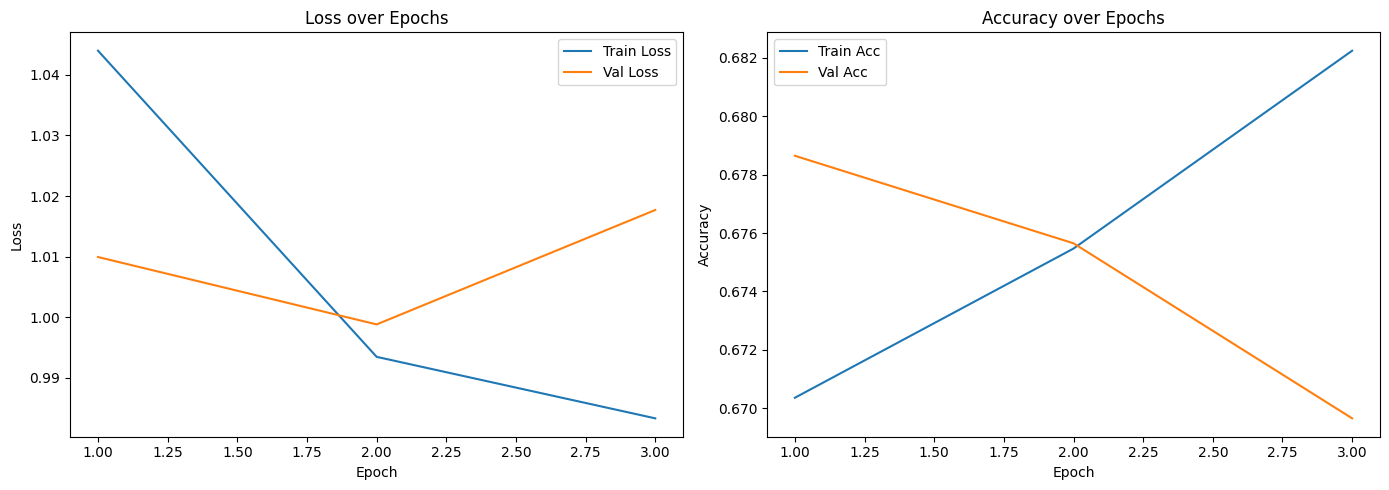

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(14, 5))

# 🔷 Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# 🔶 Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def get_all_preds(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, metadata, labels in dataloader:
            images, metadata = images.to(device), metadata.to(device)
            outputs = model(images, metadata)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

In [ ]:
# ✅ โหลดโมเดลที่ val accuracy ดีที่สุด
model = MultimodalViTWithCrossAttention().to(device)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

y_pred, y_true = get_all_preds(model, val_loader)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['dx'])  # ค่า 0–6 สำหรับ 7 class

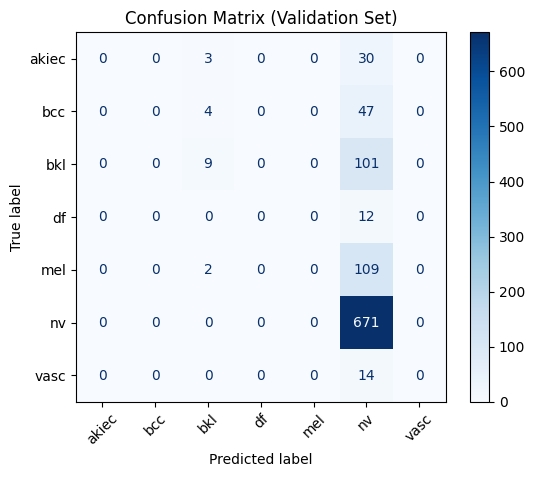

📋 Classification Report:

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        33
         bcc       0.00      0.00      0.00        51
         bkl       0.50      0.08      0.14       110
          df       0.00      0.00      0.00        12
         mel       0.00      0.00      0.00       111
          nv       0.68      1.00      0.81       671
        vasc       0.00      0.00      0.00        14

    accuracy                           0.68      1002
   macro avg       0.17      0.15      0.14      1002
weighted avg       0.51      0.68      0.56      1002



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# 🔁 Function: get predictions
def get_all_preds(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, metadata, labels in dataloader:
            images = images.to(device)
            metadata = metadata.to(device)
            outputs = model(images, metadata)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# 🧪 Get predictions and true labels
y_pred, y_true = get_all_preds(model, val_loader)

# 📊 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Validation Set)")
plt.show()

# 📋 Classification Report
print("📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


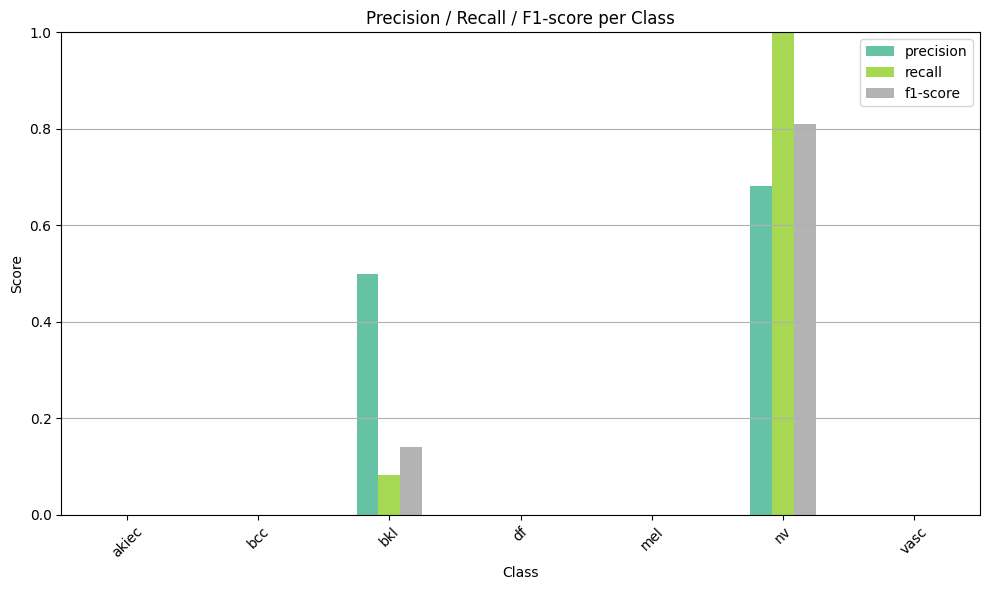

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# 🎯 Get report as dictionary
report_dict = classification_report(
    y_true, y_pred,
    target_names=label_encoder.classes_,
    output_dict=True  # <– สำคัญ! เพื่อให้แปลงเป็น DataFrame ได้
)

# 🧾 แปลงเป็น DataFrame (เอาเฉพาะ class จริงๆ ตัด 'accuracy', 'macro avg' ออก)
df_report = pd.DataFrame(report_dict).T
df_report = df_report.iloc[:-3]  # ตัด accuracy, macro avg, weighted avg ออก

# 🎨 วาด bar chart
df_report[['precision', 'recall', 'f1-score']].plot(
    kind='bar',
    figsize=(10, 6),
    ylim=(0, 1),
    colormap='Set2'
)

plt.title('Precision / Recall / F1-score per Class')
plt.ylabel('Score')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

def generate_gradcam(model, image_tensor, metadata_tensor, target_class=None):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)
    metadata_tensor = metadata_tensor.unsqueeze(0).to(device)

    # Hook เก็บ gradient ของ CLS token
    grads = {}

    def hook_fn(grad):
        grads['cls_grad'] = grad

    # Forward เพื่อให้ได้ CLS token (หลัง cross-attention)
    with torch.enable_grad():
        image_tensor.requires_grad_()

        fused_tokens = model.cross_attention(
            model.image_encoder(image_tensor),
            model.meta_encoder(metadata_tensor)
        )
        cls_token = fused_tokens[:, 0, :]  # [B, 768]
        cls_token.retain_grad()
        cls_token.register_hook(hook_fn)

        # Forward เข้าคลาสสิฟาย
        output = model.classifier(cls_token)
        pred_class = output.argmax(dim=1).item()

        # ถ้าไม่ระบุ target_class → ใช้ค่าที่โมเดลทำนาย
        if target_class is None:
            target_class = pred_class

        loss = output[0, target_class]
        loss.backward()

        grad = grads['cls_grad'][0].cpu().detach().numpy()  # [768]
        heatmap = np.abs(grad)
        heatmap = heatmap / np.max(heatmap)  # Normalize

    return heatmap, pred_class

In [ ]:
def show_gradcam_on_image(img_tensor, heatmap, alpha=0.5):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())  # Normalize image

    # Resize heatmap (ไม่มี spatial map → reshape แบบ simple)
    heatmap_resized = cv2.resize(heatmap.reshape(24, 32), (224, 224))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_color = np.float32(heatmap_color) / 255

    overlay = heatmap_color * alpha + img
    overlay = overlay / overlay.max()

    plt.figure(figsize=(5, 5))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Grad-CAM Overlay")
    plt.show()

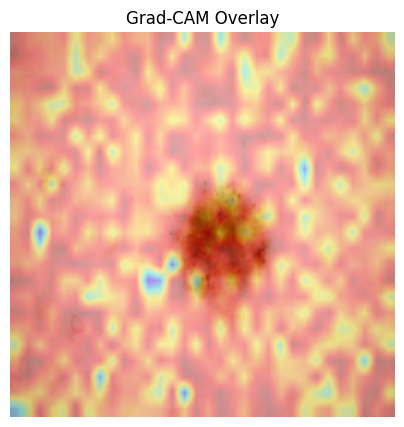

Predicted Class: nv


In [ ]:
# เลือก sample จาก validation set
image, metadata, label = val_dataset[0]

# สร้าง heatmap
heatmap, pred_class = generate_gradcam(model, image, metadata)

# แสดง overlay
show_gradcam_on_image(image, heatmap)
print(f"Predicted Class: {label_encoder.classes_[pred_class]}")